In [44]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [45]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [46]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]

Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.0894916426871495)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 108]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.4641016150727975
(change of -0.13682546025281095)
Current 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819977
(change of -0.20417052920233392)
Current ansatz: [244, 31, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964044667907
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.089491640981468)]
Initial energy: -6.327276154819977
Optimizing energy with indices [244, 31, 228, 210, 147]...
Starting point: [np.float64(0.7853981417276958), np.float64(-0.7853981819240415), np.float64(0.1635702866854681), np.float64(0.16356997269745452), np.float64(0.0)]

Current energy: -6.464101615071121
(change of -0.13682546025114384)
Current ansatz: [244, 31, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.000136128583548991

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044667907 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474280784)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 198]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [244, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053169
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.0894929267350784)]
Initial energy: -6.327276154819714
Optimizing energy with indices [244, 26, 228, 198, 135]...
Starting point: [np.float64(0.7853981509462123

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819995
(change of -0.20417052920234902)
Current ansatz: [241, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964035952707
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894916486344886)]
Initial energy: -6.327276154819995
Optimizing energy with indices [241, 74, 225, 198, 210]...
Starting point: [np.float64(-0.7853981669996093), np.float64(-0.7853981627952086), np.float64(-0.16357028615401242), np.float64(-0.16356997069742418), np.float64(0.0)]

Current energy: -6.464101615072774
(change of -0.13682546025277897)
Current ansatz: [241, 74, 225, 198, 210]
Performing final convergence check...
Total gradient norm: 0.00013505199547288632

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964035952707 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creati

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155297296
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.48507102185107)]
Initial energy: -6.123105625475226
Optimizing energy with indices [225, 79, 216, 180]...
Starting point: [np.float64(0.7854038546599069), np.float64(0.7854037259371959), np.float64(-0.12248927291404064), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154553884
(change of -0.20417052907865774)
Current ansatz: [225, 79, 216, 180]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240988012366919
Operator(s) added to ansatz: [156]
Gradients: [np.float64(-2.089491894997428)]
Initial energy: -6.327276154553884
Optimizing energy with indices [225, 79, 216, 180, 156]...
Starting point: [np.float64(0.7853981604388565), np.float64(0.7853981095762331), np.float64(-0.16357577727297534), np.float64(-0.16357144252341946), np.float64(0.0)]

Current energy: -6.464101615061043
(change of -0.1368254605071595)
Current ansatz: [225, 79, 216, 180, 156]
Performing final convergence check...
Total gradient norm: 0.00014295794031607994

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240988012366919 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating l

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734934)]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 210]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float64(0.16357019740836948), np.float64(-0.16356963668286137), np.float64(0.0)]

Current energy: -6.464101615134318
(change of -0.1368254603146104)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 2.9260899740755612e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474280784)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 198]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [244, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053169
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926735078)]
Initial energy: -6.327276154819714
Optimizing energy with indices [244, 26, 228, 198, 210]...
Starting point: [np.float64(0.7853981509462123)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113274
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 26, 228]...
Starting point: [np.float64(-0.7853981718257758), np.float64(0.7853981815917098), np.float64(0.0)]

Current energy: -6.123105625617638
(change of -0.12310562561762772)
Current ansatz: [241, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441738
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474288693)]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 210]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819988
(change of -0.2041705292023499)
Current ansatz: [241, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138126
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491643867201)]
Initial energy: -6.327276154819988
Optimizing energy with indices [241, 26, 228, 210, 198]...
Starting point: [np.float64(-0.7853981604483139), np.float64(0.7853981623217249), np.float64(0.16357028648498867), np.float64(0.16356997194327816), np.float64(0.0)]

Current energy: -6.464101615071929
(change of -0.13682546025194053)
Current ansatz: [241, 26, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013555110317705658

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138126 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617644
(change of -0.12310562561763749)
Current ansatz: [244, 31, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201327163
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710484797025)]
Initial energy: -6.123105625617644
Optimizing energy with indices [244, 31, 210, 201]...
Starting point: [np.float64(0.7853981648267889), np.float64(-0.785398161917778), np.float64(0.12248927961411428), np.float64(0.0)]

Current energy: -6.327276154819977
(change of -0.20417052920233303)
Current ansatz: [244, 31, 210, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042410177
Operator(s) added to ansatz: [75]
Gradients: [np.float64(2.08949164296387)]
Initial energy: -6.327276154819977
Optimizing energy with indices [244, 31, 210, 201, 75]...
Starting point: [np.float64(0.7853981644220853),

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 228]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.1231056256176366)
Current ansatz: [241, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441852
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047428929)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 198]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819712
(change of -0.2041705292020648)
Current ansatz: [241, 31, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053182
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.089492926734877)]
Initial energy: -6.327276154819712
Optimizing energy with indices [241, 31, 228, 198, 45]...
Starting point: [np.float64(-0.7853981510104416), np.float64(-0.785398174208182), np.float64(0.163570197408367), np.float64(-0.16356963668287464), np.float64(0.0)]

Current energy: -6.464101614754331
(change of -0.13682545993461925)
Current ansatz: [241, 31, 228, 198, 45]
Performing final convergence check...
Total gradient norm: 0.00026578794938720884

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096258053182 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752464806151
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.48507018232123)]
Initial energy: -6.1231056251565095
Optimizing energy with indices [228, 31, 198, 216]...
Starting point: [np.float64(-0.7854083594299881), np.float64(-0.7854119606470162), np.float64(-0.12248905661368972), np.float64(0.0)]

Current energy: -6.3272761540477624
(change of -0.20417052889125298)
Current ansatz: [228, 31, 198, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409327186585335
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.089515136466004)]
Initial energy: -6.3272761540477624
Optimizing energy with indices [228, 31, 198, 216, 225]...
Starting point: [np.float64(-0.7854062333533177), np.float64(-0.7854112677521524), np.float64(-0.16356354211914162), np.float64(-0.16356761613239554), np.float64(0.0)]

Current energy: -6.4641016145145045
(change of -0.13682546046674204)
Curr

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0003146268345607649

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409327186585335 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438682523)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 57]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072774
(change of -0.13682546025278697)
Current ansatz: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.000135056081442826

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474280784)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 198]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [244, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053169
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926735078)]
Initial energy: -6.327276154819714
Optimizing energy with indices [244, 26, 228, 198, 210]...
Starting point: [np.float64(0.7853981509462123), np.float64(0.7853981644537731), np.float64(0.1635701974083778), np.float64(-0.1635696366828293), np.float64(0.0)]

Current energy: -6.464101614646871
(change of -0.13682545982715677)
Current ansatz: [244, 26, 228, 198, 210]
Performing final convergence check...
Total gradient norm: 0.0002921624091770451

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096258053169 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916426871504)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 147]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072783
(change of -0.13682546025279674)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 147]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072685
(change of -0.13682546025269726)
Current ansatz: [244, 79, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00013508605784767053

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682814)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 210]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.1224892796166995), np.float64(0.0)]

Current energy: -6.327276154765011
(change of -0.20417052920252932)
Current ansatz: [228, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069117
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491643863324)]
Initial energy: -6.327276154765011
Optimizing energy with indices [228, 79, 228, 210, 198]...
Starting point: [np.float64(-0.78539470657713), np.float64(0.7853982468601272), np.float64(0.16357028648716854), np.float64(0.16356997194353076), np.float64(0.0)]

Current energy: -6.464101615018015
(change of -0.13682546025300368)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 147]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819707
(change of -0.2041705292020648)
Current ansatz: [241, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409625805317495
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894929267349442)]
Initial energy: -6.327276154819707
Optimizing energy with indices [241, 79, 228, 147, 210]...
Starting point: [np.float64(-0.7853981622864769), np.float64(0.7853981648066234), np.float64(0.1635701974083699), np.float64(-0.16356963668285893), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615134799
(change of -0.13682546031509268)
Current ansatz: [241, 79, 228, 147, 210]
Performing final convergence check...
Total gradient norm: 2.784121640913492e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409625805317495 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200768382
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710481682663)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 201]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.1224892795338588), np.float64(0.0)]

Current energy: -6.327276154819708
(change of -0.20417052920206213)
Current ansatz: [244, 79, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531913
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0894929267348763)]
Initial energy: -6.327276154819708
Optimizing energy with indices [244, 79, 216, 201, 225]...
Starting point: [np.float64(0.7853981633974537), np.float64(0.7853981633975231), np.float64(-0.16357019740839485), np.float64(0.16356963668288216), np.float64(0.0)]

Current energy: -6.464101615135399
(change of -0.13682546031569132)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001361285843518749

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044667907 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531783
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734875)]
Initial energy: -6.327276154819699
Optimizing energy with indices [244, 79, 228, 147, 210]...
Starting point: [np.float64(0.7853981646904773), np.float64(0.7853981643651435), np.float64(0.16357019740836662), np.float64(-0.1635696366828739), np.float64(0.0)]

Current energy: -6.464101615132633
(change of -0.1368254603129344)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955728
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868942)]
Initial energy: -6.123105625610642
Optimizing energy with indices [228, 74, 225, 210]...
Starting point: [np.float64(-0.7853983869831797), np.float64(-0.7853991695302367), np.float64(-0.12248869758310571), np.float64(0.0)]

Current energy: -6.327276154816355
(change of -0.20417052920571255)
Current ansatz: [228, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096256714494
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929485632674)]
Initial energy: -6.327276154816355
Optimizing energy with indices [228, 74, 225, 210, 198]...
Starting point: [np.float64(-0.785398438893094), np.float64(-0.7853991591701955), np.float64(-0.1635701984907769), np.float64(0.1635696317030657), np.float64(0.0)]

Current energy: -6.464101615132105
(change of -0.13682546031574994)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000005)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 216]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.1231056256176455
(change of -0.1231056256176366)
Current ansatz: [244, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768382
Operator(s) added to ansatz: [30]
Gradients: [np.float64(2.4850710481682663)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 30]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 147]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072685
(change of -0.13682546025269726)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605784767053

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)
Pool will be tiled from 22 ops


## Run ADAPT at larger size to get a sequence of circuits.

In [47]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [48]:
# Now go to the larger size.
new_l = 2 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 8
Got DMRG energy -1.34997e+01
Tiled pool has 88 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -6.999999999999975
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.99999999999997
Operator 1: 3.999999999999984
Operator 2: -3.9999999999999902
Operator 3: 3.999999999999996
Operator 4: -3.9999999999999947
Operator 5: 3.9999999999999862
Operator 6: -3.999999999999985
Operator 7: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 6: -2.4775948466145925
Operator 9: 3.6894586733081054
Operator 10: -0.7031172305868252
Operator 11: 1.3681172484456208
Operator 12: 2.6269289608062825
Operator 13: 2.4450075611207454
Operator 15: -2.092897051278248
Operator 18: -1.6499760789000617
Operator 19: -2.8944271910874337
Operator 20: 1.1175787285947885
Operator 26: -2.094789138544006
Operator 28: -1.36811724844562
Operator 29: 3.6894586733081054
Operator 30: 2.4775948466145925
Operator 32: 2.4775948466145916
Operator 33: -1.042778505634707
Operator 34: 0.6118406338027392
Operator 35: -3.6894586733081054
Operator 36: 2.092897051278247
Operator 37: 1.042778505634707
Operator 38: 1.36811724844562
Operator 39: 1.6499760789000617
Operator 40: 2.8944271910874337
Operator 41: -2.4775948466145925
Operator 42: 1.2463752755690747
Operator 44: -2.6269289608062825
Operator 45: -2.4450075611207454
Operator 47: 2.094789138544005
Operator 49: -2.8944271910874337
Operator 51: 1.1862872200547296
Operator 52: -1.64588169960396
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 6: -1.0297000920742923
Operator 8: -0.5048489811931155
Operator 9: 0.6521802234624059
Operator 10: -1.5946377604822302
Operator 11: 1.7793330282670845
Operator 12: -1.4497409133076185
Operator 13: -0.05973161634925864
Operator 14: -1.9081489655464878
Operator 15: -2.1124765588077428
Operator 16: 1.4071285652794498
Operator 17: -1.6042844778395304
Operator 18: 1.2995025213804
Operator 19: -2.024239587469195
Operator 20: 1.726208220459713
Operator 22: 1.5013282808776283
Operator 23: -0.6531630524722879
Operator 24: -0.43871550046442487
Operator 26: -1.252613424166736
Operator 28: -1.555963646240567
Operator 29: 0.22188360753367367
Operator 30: 2.1730673125540276
Operator 32: 1.0297000920742925
Operator 33: -0.4402898408565843
Operator 34: 0.5299509172102582
Operator 36: 2.1124765588077423
Operator 37: -1.1499783412718547
Operator 38: 1.6725724707521104
Operator 39: -2.0685163423739374
Operator 41: -2.1730673125540285
Operator 42: 1.7377204875270456
Operator 43: -1.69505219700846

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Optimization terminated successfully.
         Current function value: -12.684932
         Iterations: 15
         Function evaluations: 22
         Gradient evaluations: 22

Current energy: -12.684931726051246
(change of -0.18620873746693434)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.5240759699065302
Operator 2: -0.5240759698057018
Operator 3: 0.4918824653680484
Operator 4: 0.16567522100226562
Operator 6: 0.2552575443196594
Operator 7: -0.0025718487331164858
Operator 8: -0.49281469092063
Operator 9: 0.7344314420732214
Operator 10: -1.3233579087969576
Operator 11: 1.4055053933417008
Operator 12: -1.2099631960039716
Operator 13: -0.5865396628347288
Operator 14: -1.4915704358515804
Operator 15: 0.5865396615484892
Operator 16: 1.2099631963179867
Operator 17: -1.4055053937283932
Operator 18: 1.3233579108270037
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.234246
         Iterations: 15
         Function evaluations: 41
         Gradient evaluations: 29

Current energy: -13.234245879497347
(change of -0.15086760487442774)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14]
On iteration 13.

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.02551694722386e-08
Operator 1: -2.2226841936076602e-07
Operator 2: 2.26933813685104e-08
Operator 3: -1.2997699079531078e-07
Operator 4: 1.213591342974496e-07
Operator 5: 3.8118756426949035e-08
Operator 7: -4.703633482705527e-08
Operator 8: 3.860149500045651e-08
Operator 9: -6.005027494704329e-08
Operator 10: 0.18245105502577616
Operator 11: -0.65088973295822
Operator 12: -1.852637454147271
Operator 13: -0.11965114515354995
Operator 15: 0.1196511528275708
Operator 16: 1.85263745434798
Operator 17: 0.650889728032772
Operator 18: -0.18245105330918338
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.339218
         Iterations: 23
         Function evaluations: 91
         Gradient evaluations: 78

Current energy: -13.339217758437652
(change of -0.10497187894030446)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -6.682284936498917e-08
Operator 1: -2.838859883974587e-08
Operator 2: 8.124874806281213e-08
Operator 3: 2.808558682843021e-08
Operator 4: -7.012943159523388e-08
Operator 5: -7.751664758345878e-08
Operator 6: 1.3783952059615023e-08
Operator 7: 5.278385645235417e-08
Operator 9: -7.023496767510906e-08
Operator 10: 0.20398868812021154
Operator 11: -0.06029311662790207
Operator 12: -0.2772512013572112
Operator 13: -0.10765948361503544
Operator 14: 5.721538415038378e-07
Operator 15: -0.11637497330476415
Operator 16: 0.21839840454747694
Operator 17: 0.136

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.344008
         Iterations: 17
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -13.344007889667786
(change of -0.004790131230134165)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -6.228357771614901e-07
Operator 1: 1.238672961423326e-08
Operator 2: 6.279456753743862e-07
Operator 3: -7.612673488532895e-07
Operator 4: 9.190482965770741e-07
Operator 5: 9.001752932676077e-07
Operator 6: -1.3770454728324194e-07
Operator 7: 5.764589094438277e-07
Operator 8: -6.738429515242006e-08
Operator 9: -8.34707799879375e-07
Operator 10: 0.22988763268489046
Operator 11: -0.20061951865079866
Operator 12: -0.23307125670639306
Operator 13: -0.10928480486327319
Operator 14: 5.391557890945938e-07
Operator 15: 0.016441273200319212
Operator 16:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.376729
         Iterations: 25
         Function evaluations: 80
         Gradient evaluations: 67

Current energy: -13.37672909807289
(change of -0.0327212084051034)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30]
On iteration 16.

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.314911752067996e-07
Operator 1: 2.836612970069652e-07
Operator 2: -3.43461740826001e-07
Operator 3: 3.371103673988074e-08
Operator 4: 1.2189599107870208e-07
Operator 5: 4.434039786727073e-07
Operator 6: -2.417241135727055e-08
Operator 7: -3.041672957948549e-07
Operator 8: -7.93235366627898e-08
Operator 9: 3.4181014685330524e-07
Operator 10: 0.12773339237650913
Operator 11: -0.12465780485790062
Operator 12: -0.2764319780640849
Operator 13: -0.14100207607261572
Operator 14: 3.47728135755158e-07
Operator 15: -0.02573419467967765
Operator 16: 0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.384815
         Iterations: 22
         Function evaluations: 53
         Gradient evaluations: 43

Current energy: -13.384815448772038
(change of -0.008086350699148426)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12]
On iteration 17.

*** ADAPT-VQE Iteration 18 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.3209912551465086e-06
Operator 1: -6.59301552027175e-06
Operator 2: -4.517466853370955e-07
Operator 3: -3.2891509649246586e-07
Operator 4: -1.0347369974184062e-06
Operator 5: -3.7822265806439215e-06
Operator 6: 1.355358976889206e-07
Operator 7: -3.030892513029848e-06
Operator 8: 1.8513152330347504e-06
Operator 9: 4.995025733034453e-07
Operator 10: 0.18484394921655486
Operator 11: -0.06556126056482425
Operator 12: 2.064187107292482e-07
Operator 13: -0.1338251683354213
Operator 14: -0.09547105612913281
Operator 15: 0.06795076442087863
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.441296
         Iterations: 26
         Function evaluations: 82
         Gradient evaluations: 70

Current energy: -13.441295872877433
(change of -0.05648042410539489)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55]
On iteration 18.

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -2.3478733970905274e-08
Operator 2: -2.0740505202176962e-08
Operator 3: -1.7710649558022595e-08
Operator 4: 2.4620554484044987e-08
Operator 5: -1.814920341271231e-08
Operator 9: 1.4841735174186965e-08
Operator 10: 0.18523781666097439
Operator 11: -0.07465341034127701
Operator 12: -0.02524691138451427
Operator 13: -0.34330986567872834
Operator 14: -0.22232807085701586
Operator 15: 0.15293719234097158
Operator 16: 0.07804091246561437
Operator 17: 0.2372654011631587
Operator 18: -0.07340803968132352
Operator 19: 0.10185090316469887
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.454807
         Iterations: 20
         Function evaluations: 71
         Gradient evaluations: 60

Current energy: -13.454807413368362
(change of -0.013511540490929619)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13]
On iteration 19.

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.904277128928934e-07
Operator 1: 6.291349963216675e-07
Operator 2: 2.6397171269954e-06
Operator 3: 2.692103418466818e-06
Operator 4: -4.170417873261556e-06
Operator 5: 1.0625954148055922e-06
Operator 6: -1.4556630059756742e-08
Operator 7: -1.1202553112932279e-07
Operator 8: 3.1477099815546694e-08
Operator 9: -1.776543714915313e-06
Operator 10: 0.15994327216887383
Operator 11: -0.04790672626548892
Operator 12: -0.0287259258632597
Operator 14: -0.20900399122454358
Operator 15: 0.15246340513689785
Operator 16: 0.03538754538852119

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.458705
         Iterations: 17
         Function evaluations: 59
         Gradient evaluations: 48

Current energy: -13.458705220781617
(change of -0.003897807413254739)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23]
On iteration 20.

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.04639792144862e-06
Operator 1: 3.371684151510303e-05
Operator 2: -4.155818827313235e-06
Operator 3: 1.2413961755998427e-05
Operator 4: -9.686261986861962e-06
Operator 5: 5.366005258583008e-07
Operator 6: 9.522250956971768e-07
Operator 7: 1.0080268027925319e-05
Operator 8: -8.082193323137346e-06
Operator 9: 7.870655061141551e-06
Operator 10: 0.13755074412714305
Operator 11: -0.002909663166902727
Operator 12: 0.007061283235051356
Operator 13: -9.257988799360796e-07
Operator 14: -0.19615945809348975
Operator 15: 0.148320293

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.460652
         Iterations: 30
         Function evaluations: 90
         Gradient evaluations: 78

Current energy: -13.460651807101687
(change of -0.001946586320070054)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57]
On iteration 21.

*** ADAPT-VQE Iteration 22 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.8502383395402333e-06
Operator 1: -1.6866386238767461e-06
Operator 2: 1.2728152810614901e-06
Operator 3: -1.5365571811032375e-06
Operator 4: 1.5231911003610321e-06
Operator 5: -1.8905878753153194e-07
Operator 6: -1.638310302309225e-07
Operator 7: 1.1445706897816876e-06
Operator 8: 3.073728571702239e-07
Operator 9: -1.713323550145418e-06
Operator 10: 0.1213641553979107
Operator 11: 0.021439118353882014
Operator 12: 0.006498452974493947
Operator 13: -0.00045339592571363465
Operator 14: -0.21679092144539042
Operator 15: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.478333
         Iterations: 28
         Function evaluations: 57
         Gradient evaluations: 46

Current energy: -13.47833303006338
(change of -0.017681222961693166)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48]
On iteration 22.

*** ADAPT-VQE Iteration 23 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.591933077453163e-07
Operator 1: -1.347615909621277e-06
Operator 2: -8.745666745229447e-08
Operator 3: -3.5561992063040584e-07
Operator 4: 2.611010832195837e-07
Operator 5: -9.990194373946278e-08
Operator 6: -1.0011100504623202e-08
Operator 7: -7.021568998906978e-07
Operator 8: 4.3372234853919824e-07
Operator 9: -3.108300014858373e-08
Operator 10: 0.045909779697120796
Operator 11: 0.0093826599696443
Operator 12: -0.0492524995367433
Operator 13: -0.06912156111587155
Operator 14: -0.009385093217853597
Operator 15: 0.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.481360
         Iterations: 30
         Function evaluations: 130
         Gradient evaluations: 116

Current energy: -13.481360062641082
(change of -0.0030270325777017604)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48, 80]
On iteration 23.

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 4: 1.3730655723520613e-08
Operator 5: 2.4951583278698397e-08
Operator 7: -1.02794039669174e-08
Operator 10: 0.053160095873608766
Operator 11: 0.00637629421269648
Operator 12: -0.040611926343322266
Operator 13: -0.033386586470363966
Operator 14: 0.006518444138521469
Operator 15: 0.07308007029475538
Operator 16: -0.033137929289167645
Operator 17: 0.08297639878839608
Operator 18: -0.23826538953770243
Operator 19: -0.010055957481644721
Operator 20: -0.10341934181420762
Operator 21: 0.13008146743285384
Operator 22: -

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.484508
         Iterations: 26
         Function evaluations: 87
         Gradient evaluations: 77

Current energy: -13.484507568543641
(change of -0.003147505902559189)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48, 80, 85]
On iteration 24.

*** ADAPT-VQE Iteration 25 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.735520455432461e-07
Operator 1: 2.2395324867641175e-06
Operator 2: -4.6121663554998804e-07
Operator 3: 8.745225250628152e-07
Operator 4: -7.41333154863355e-07
Operator 5: 2.398513272439118e-07
Operator 6: 7.867444816456182e-08
Operator 7: 3.71051573772041e-07
Operator 8: -5.399836683697701e-07
Operator 9: 7.699314277243019e-07
Operator 10: 0.053862209136915716
Operator 11: 0.004095832782708524
Operator 12: -0.043421196306490065
Operator 13: -0.03718476175962005
Operator 14: 0.0067863348418568115
Operator 1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.488793
         Iterations: 29
         Function evaluations: 87
         Gradient evaluations: 77

Current energy: -13.488793267188692
(change of -0.004285698645050573)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48, 80, 85, 64]
On iteration 25.

*** ADAPT-VQE Iteration 26 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.192996801182346e-06
Operator 1: 1.3832312167894045e-06
Operator 2: -1.4100235057323829e-06
Operator 3: 2.4724733780345787e-06
Operator 4: -2.857381996790309e-06
Operator 5: 5.455199136861211e-08
Operator 6: 2.2924056303219587e-07
Operator 7: -2.224086119273494e-06
Operator 8: -2.300252548749493e-07
Operator 9: 2.1468860366136155e-06
Operator 10: 0.05408916075627562
Operator 11: 0.005152370999528862
Operator 12: -0.03537138175078264
Operator 13: -0.03596771928761536
Operator 14: -0.0027227337768143123
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.490965
         Iterations: 26
         Function evaluations: 67
         Gradient evaluations: 57

Current energy: -13.490965317140525
(change of -0.002172049951832733)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48, 80, 85, 64, 74]
On iteration 26.

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 7.163581536323571e-06
Operator 1: -1.171791194047242e-05
Operator 2: -3.6934925317089196e-06
Operator 3: -6.308121835163494e-07
Operator 4: 9.084923948687873e-07
Operator 5: -1.4864046828169664e-06
Operator 6: 2.3450871765025132e-07
Operator 7: -9.26781454528569e-06
Operator 8: 3.159091270151567e-06
Operator 9: 3.4784487726591262e-06
Operator 10: 0.00025752470592968425
Operator 11: 0.004164537905832076
Operator 12: -0.03979104931961705
Operator 13: -0.02973270345042475
Operator 14: -0.007642729305045

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.491559
         Iterations: 28
         Function evaluations: 73
         Gradient evaluations: 63

Current energy: -13.491559253310998
(change of -0.0005939361704729862)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48, 80, 85, 64, 74, 78]
On iteration 27.

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.7691786330098491e-06
Operator 1: -5.585365350120608e-06
Operator 2: 3.308732833717798e-06
Operator 3: -4.776881403267819e-06
Operator 4: 5.1090703978573515e-06
Operator 5: 5.617937100306503e-06
Operator 6: -3.2647053368160817e-07
Operator 7: -3.2203845415357257e-07
Operator 8: 1.3065824071281304e-06
Operator 9: -4.76643941726973e-06
Operator 10: 0.0170763234764407
Operator 11: 0.0024954822770199897
Operator 12: -0.04050730656713586
Operator 13: -0.029587245183172795
Operator 14: -0.0098804228

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.494007
         Iterations: 32
         Function evaluations: 63
         Gradient evaluations: 53

Current energy: -13.494007093029552
(change of -0.0024478397185543344)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48, 80, 85, 64, 74, 78, 84]
On iteration 28.

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -9.5496321325661e-07
Operator 1: -8.748125147658992e-06
Operator 2: -1.9248487800327396e-06
Operator 3: -1.9079860577031482e-06
Operator 4: 2.717227265414124e-06
Operator 5: -7.78925100861777e-06
Operator 6: -4.907396701971795e-07
Operator 7: -1.6471043975674338e-06
Operator 8: 2.3254203345679763e-06
Operator 9: 1.3562323898375084e-06
Operator 10: 0.0006198487170023524
Operator 11: -0.015037544685292241
Operator 12: -0.003551688002478604
Operator 13: -0.010307186145681543
Operator 14: -0.006

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -13.494743
         Iterations: 32
         Function evaluations: 68
         Gradient evaluations: 57

Current energy: -13.494742653721502
(change of -0.0007355606919503543)
Current ansatz: [85, 71, 50, 84, 35, 40, 55, 41, 87, 53, 52, 71, 14, 37, 21, 30, 12, 55, 13, 23, 57, 48, 80, 85, 64, 74, 78, 84, 21]
On iteration 29.

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -7.089115133043777e-07
Operator 1: -9.108064871445748e-06
Operator 2: -2.616660905729873e-07
Operator 3: -6.382303574442583e-06
Operator 4: 8.166552716293296e-06
Operator 5: 1.928741491234731e-06
Operator 6: -2.57268163281546e-07
Operator 7: -2.396170629775929e-06
Operator 8: 2.237316530589919e-06
Operator 9: -1.7058096761224384e-06
Operator 10: 0.007918132152946114
Operator 11: -0.03380317275067819
Operator 12: -0.009466562527852686
Operator 13: -0.02918306064782556
Operator 14: -0.0061

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [49]:
for circuit in circuits:
    print(circuit.depth())

8
15
20
27
34
41
48
55
62
69
76
83
90
97
104
111
118
125
132
139
146
153
160
167
174
181
188
195
202
209


Text(0, 0.5, 'Energy error')

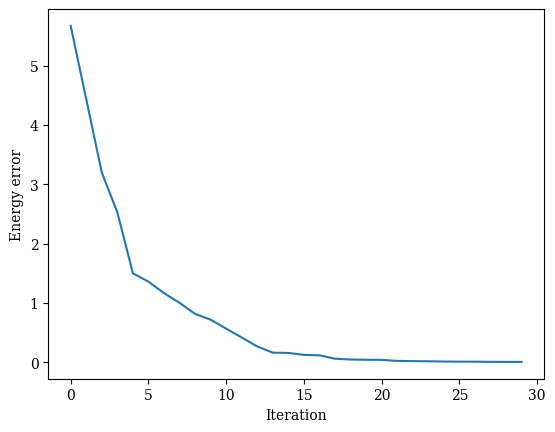

In [62]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [51]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [52]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [53]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

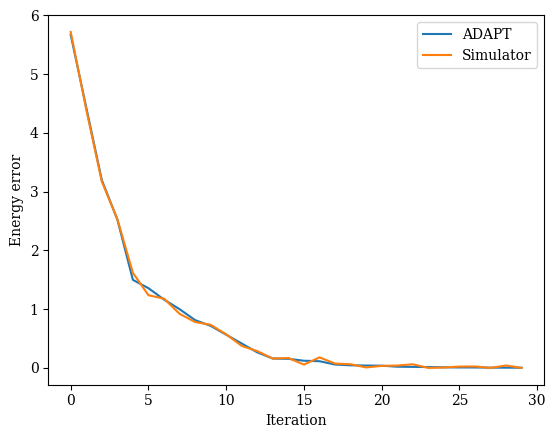

In [63]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [55]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [56]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sampler.run([to_run], shots=30_000)
    job = sim.run(to_run)
    # bit_array = job.result()[0].data.meas
    # bit_array = job.result().data().meas
    counts = job.result().data()['counts']
    bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 8, 'cx': 4, 'x': 3, 'rx': 2, 'barrier': 2, 'u2': 1, 'rz': 1, 'h': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 8, 'measure': 8, 'rx': 4, 'x': 3, 'h': 3, 'barrier': 3, 'rz': 2, 'u2': 1})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 10, 'measure': 8, 'rx': 6, 'h': 5, 'barrier': 4, 'x': 3, 'rz': 3, 'u2': 1})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 14, 'rx': 8, 'measure': 8, 'h': 7, 'barrier': 5, 'rz': 4, 'x': 3, 'u2': 1})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 20, 'rx': 10, 'h': 9, 'measure': 8, 'barrier': 6, 'rz': 5, 'x': 3, 'u2': 1})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 24, 'rx': 12, 'h': 11, 'measure': 8, 'barrier': 7, 'rz': 6, 'x': 3, 'u2': 1})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 28, 'rx': 14, 'h': 13, 'barrier': 8, 'measure': 8, 'rz': 7, 

In [57]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

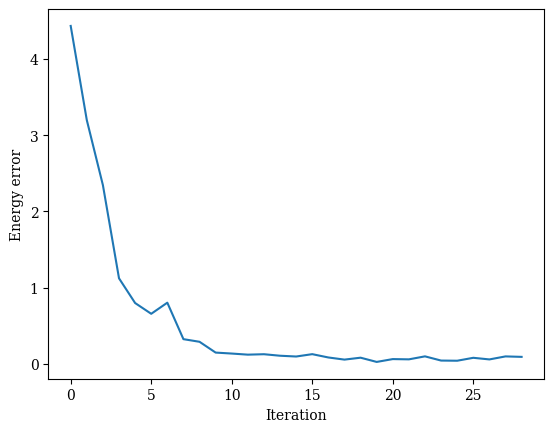

In [58]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [59]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

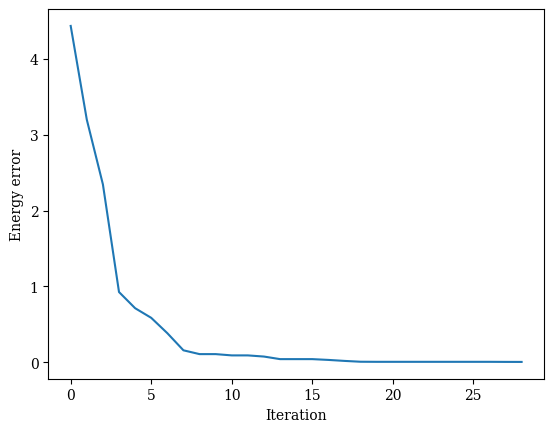

In [60]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

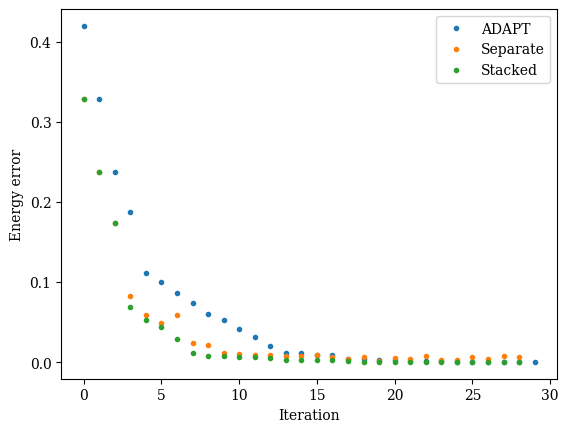

In [61]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()